In [25]:
# Importing the libraries and data
from data_cleaning_2 import df_network
from data_cleaning_2 import df
from data_cleaning_2 import print_to_file
import networkx as nx
import numpy as np
import pandas as pd
#!pip install pyvis
from pyvis.network import Network
import matplotlib.pyplot as plt
#!pip install python-louvain --upgrade


In [26]:
df_network.head()
print(df_network['Author'].unique().shape)

(185052,)


In [27]:
# Create a new dataframe that includes only the 'Author' and 'Mentioned Authors' columns
network_data = df_network[['Author', 'Mentioned Authors']]

# Group the data by 'Author' and 'Mentioned Authors', and count the number of occurrences to get the 'weight'
network_data = network_data.groupby(['Author', 'Mentioned Authors']).size().reset_index(name='weight')

# Print the resulting dataframe to check the output, and save it to a CSV file
network_data.to_csv('Mention network data.csv', index=False)

# Show the top 5 rows of the dataframe
network_data.head()

,Author,Mentioned Authors,weight
0,0000007zeg,sashibu2,1
1,000000_otaku,laplusdarknesss,1
2,000000asterisk,hololivetv,1
3,000000asterisk,laplusdarknesss,1
4,000000asterisk,sakamatachloe,1


In [28]:
# Create a new dataframe that includes only the columns we need
node_attr_all = df[['Author', 'Full Name', 'Account Type', 'Language', 'Twitter Followers', 'Twitter Retweets', 'Twitter Tweets', 'Reach (new)', 'Twitter Reply Count']].copy()

# Group the data by 'Author' and aggregate the columns to get the desired output
node_attr = node_attr_all.groupby(['Author']).agg(
    Full_Name=('Full Name', 'first'),
    Account_Type=('Account Type', 'first'),
    Language=('Language', lambda x: ','.join(set(x))),
    Twitter_Followers=('Twitter Followers', 'max'), # important
    Twitter_Retweets=('Twitter Retweets', 'max'), # important
    Twitter_Tweets_max=('Twitter Tweets', 'max'),
    Twitter_Tweets_min=('Twitter Tweets', 'min'),
    Reach=('Reach (new)', 'max'),
    Twitter_Reply_Count=('Twitter Reply Count', 'max'), # important
).reset_index()

# Calculate the number of posts/tweets within the time period
node_attr['Twitter_Tweets_within'] = node_attr['Twitter_Tweets_max'] - node_attr['Twitter_Tweets_min']
node_attr.drop(['Twitter_Tweets_min'], axis=1, inplace=True)

# Print the final dataframe
print(node_attr[['Author', 'Full_Name', 'Account_Type', 'Language', 'Twitter_Followers', 'Twitter_Retweets', 'Twitter_Tweets_max', 'Reach', 'Twitter_Reply_Count', 'Twitter_Tweets_within']])


                Author                        Full_Name Account_Type Language   
0           0000007zeg              0000007Zeg (Zeg_ゼグ)   individual       ja  \
1         000000_otaku           000000_otaku (星Otaku🎨)   individual       ja   
2       000000asterisk  000000asterisk (黒井星✱人形執事Vtuber)   individual       ja   
3        00000mii00000              00000Mii00000 (Mii)   individual       ja   
4            00002e000              00002E000 (May_Day)   individual       ja   
...                ...                              ...          ...      ...   
185047        zzzz_281                  zzzz_281 (さ🈂️の)   individual       ja   
185048         zzzzund                zzzzund (ずんだ🦋【レ】)   individual       ja   
185049       zzzzz_x_x                   zzZZZ_x_x (まろ)   individual       ja   
185050    zzzzzero1456              zzzzzero1456 (石ころん)   individual       ja   
185051  zzzzzzzzzz0123      Zzzzzzzzzz0123 (ミカン@ミュート推奨)   individual       ja   

       Twitter_Followers Tw

In [29]:
# Create the network using the 'from_pandas_edgelist' function and set the node attributes
nw_G = nx.from_pandas_edgelist(network_data, 'Author', 'Mentioned Authors', edge_attr='weight',create_using=nx.DiGraph())

# Print the total network information
print("Total network information:")
print("Number of nodes: ", nx.number_of_nodes(nw_G))
print("Number of edges: ", nx.number_of_edges(nw_G))
print("Density: ", nx.density(nw_G))
print("*" * 100)

# Calculate the weighted degrees and print the maximum weighted degree, median value of the weighted degree, and 75th percentile
weighted_degrees = dict(nx.degree(nw_G, weight='weight'))
max_degree = max(weighted_degrees.values())
media_degree = np.median(list(weighted_degrees.values()))
print("The maximum weighted degree is: {0}, \n The median value of the weighted degree is: {1}".format(max_degree,media_degree))
print("75th percentile : {}".format(np.percentile(list(weighted_degrees.values()), 75)))

# Create a dataframe of the weighted degrees
weighted_degree_df = pd.DataFrame([weighted_degrees]).T
weighted_degree_df.reset_index(inplace=True)
weighted_degree_df.columns=['Author','Weighted Degree']

# Create a dataframe of the degrees (in and out)
degrees_df =pd.DataFrame([dict(nx.degree(nw_G))]).T
degrees_df.reset_index(inplace=True)
degrees_df.columns=['Author','Degree']

# Calculate the in-degree centrality and create a dataframe of it
in_degrees=nx.in_degree_centrality(nw_G)
in_deg_centrality = pd.DataFrame.from_dict(nx.in_degree_centrality(nw_G),orient='index',columns=['in_degree_Centrality'])
in_deg_centrality.reset_index(inplace=True)
in_deg_centrality.rename(columns={'index':'Author'},inplace=True)

# Calculate the out-degree centrality and create a dataframe of it
out_deg_centrality = pd.DataFrame.from_dict(nx.out_degree_centrality(nw_G),orient='index',columns=['out_degree_Centrality'])
out_deg_centrality.reset_index(inplace=True)
out_deg_centrality.rename(columns={'index':'Author'},inplace=True)

Total network information:
Number of nodes:  186102
Number of edges:  347085
Density:  1.0021577697623994e-05
****************************************************************************************************
The maximum weighted degree is: 74873, 
 The median value of the weighted degree is: 2.0
75th percentile : 3.0


In [30]:
# Calculate eigenvector centrality for in-edges and create a dataframe of it
eigenvector_centrality_in = pd.DataFrame.from_dict(nx.eigenvector_centrality(nw_G,weight='weight'),orient='index',columns=['eigenvector_centrality_in']) 
eigenvector_centrality_in.reset_index(inplace=True)
eigenvector_centrality_in.rename(columns={'index':'Author'},inplace=True)

# Merge all the dataframes into one
measure_df = pd.merge(weighted_degree_df, degrees_df, on='Author', how='outer')
measure_df = pd.merge(measure_df, in_deg_centrality, on='Author', how='outer')
measure_df = pd.merge(measure_df, out_deg_centrality, on='Author', how='outer')
measure_df = pd.merge(measure_df, eigenvector_centrality_in, on='Author', how='outer')
measure_df = pd.merge(measure_df, node_attr, on='Author', how='left')

# Filter out rows with missing data
print("There are {0} Ids in the Mention network, {1} of them have 0 post".format(measure_df.shape[0], measure_df['Twitter_Followers'].isnull().sum()))
measure_df.dropna(subset=['Twitter_Followers','Twitter_Tweets_max'], inplace=True)
print("{} Ids left in the output table".format(measure_df.shape[0]))

# Sort the dataframe based on the weighted degree
measure_df.sort_values('Weighted Degree', ascending=False, inplace=True)

# Save the dataframe to a CSV file
measure_df.to_csv('measure_df.csv', index=False)


There are 186102 Ids in the Mention network, 1050 of them have 0 post
185052 Ids left in the output table


In [31]:
measure_df.head()

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within
110,usadapekora,30077,6544,0.035153,0.000011,2.508462e-06,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,1397443,0,14219,48806,0,0
11,youtubejapan,27958,22562,0.119870,0.001365,2.500629e-05,YouTubeJapan (YouTube Japan),individual,ja,520150,4082,34347,1033850,139,15370
98,niziu__official,23949,4346,0.023337,0.000016,1.501726e-05,NiziU__official (NiziU),organisational,ja,809129,462,13167,167395,22,726
158,haneru_inaba,16469,2278,0.012230,0.000011,2.769555e-11,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,203461,0,86212,22122,0,0
91,karekoreya,15925,1484,0.007963,0.000011,1.546821e-08,karekoreya (ヒサメ@混血のカレコレ),individual,ja,59485,37,2459,24136,4,267


In [32]:
def user_info(df):
    # Count how many times the author was mentioned by other authors and how many times they mentioned others
    df['mentioned_by'] = network_data[network_data['Mentioned Authors'] == df['Author']].shape[0]
    df['mentioned_by_times'] = network_data[network_data['Mentioned Authors'] == df['Author']]['weight'].sum()
    df['mention_other'] = network_data[network_data['Author'] == df['Author']].shape[0]
    df['mentioned_other_times'] = network_data[network_data['Author'] == df['Author']]['weight'].sum()
    return df

# Apply user_info function to top 1000 authors in mentions and save to CSV
top1000 = measure_df.copy()
top1000.sort_values(by='Degree', ascending=False, inplace=True)
top1000 = top1000.head(1000).apply(user_info, axis=1)
top1000.to_csv('Top 1000 Authors in mentions.csv')

# Assign the node "size" attribute, using the in degree
for node in nw_G.nodes:
    node_dict = nw_G.nodes[node]
    # If the node does not have a 'size' attribute, calculate the square root of its in-degree multiplied by 500 
    # and set it as the value of the 'size' attribute
    if node_dict.get('size') is None:
        nw_G.nodes[node]['size'] = in_degrees[node]**0.5*500

# Create a dictionary with node attributes and set them in the networkx graph
node_attr_dict = node_attr.set_index('Author').to_dict('index')
nx.set_node_attributes(nw_G, node_attr_dict)


In [33]:
# Set edge attributes
edge_attr = network_data.copy()

# Create an index of edges using the combination of author and mentioned author columns
edge_attr['index'] = list(zip(edge_attr['Author'], edge_attr['Mentioned Authors']))

# Keep only the index and weight columns
edge_attr = edge_attr[['index', 'weight']]

# Convert the edge_attr dataframe to a dictionary with index as key
edge_attr_dict = edge_attr.set_index('index').to_dict('index')

# Loop through edges of the graph and assign weights from the edge_attr_dict to each edge
for edge in nw_G.edges: 
    edge_dict = nw_G.edges[edge]
    if edge_dict.get('weight') is None:
        nw_G.edges[edge]['weight'] = edge_attr_dict[edge]


In [34]:
# set a threshold and filter the sub network

def sub_network(networkx_graph, threshold):
    """
    This function filters the given network based on a threshold value for weighted degree.
    It returns the subgraph with nodes whose weighted degree is greater than the threshold.
    
    Args:
        networkx_graph: The graph to filter
        threshold: The minimum weighted degree threshold to include a node in the subgraph
        
    Returns:
        subgraph: The subgraph containing nodes with weighted degree greater than the threshold
    """
    subgraph = networkx_graph.subgraph([n for n in weighted_degrees if weighted_degrees[n] > threshold])
    
    print_to_file("Sub-network information based on threshold of {}".format(threshold))
    print_to_file(nx.info(subgraph))
    print_to_file("*" * 100)
    
    return subgraph


def draw_graph3(networkx_graph, notebook=True, output_filename='graph.html', show_buttons=True, only_physics_buttons=False):
    """
    This function accepts a networkx graph object, converts it to a pyvis network object preserving its node and edge 
    attributes, and both returns and saves a dynamic network visualization.
    
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        
    Returns:
        pyvis_graph.show: Pyvis network object showing the dynamic network visualization
    """
    # make a pyvis network
    pyvis_graph = Network(notebook=notebook, height="1000px", width="1000px", directed=True)#, bgcolor='#222222', font_color='white')
    
    # for each node and its attributes in the networkx graph   
    for node, node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(str(node), **node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source, target, edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value'] = edge_attrs['weight']
        
        # add the edge
        pyvis_graph.add_edge(str(source), str(target), **edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    print("Plot Done!")
    print("*" * 100)
    
    return pyvis_graph.show(output_filename)


In [35]:
# Importing the community detection algorithm
import community.community_louvain as community_louvain

# Create a non-directional network for the community
nw_G_nd = nx.from_pandas_edgelist(network_data, 'Author', 'Mentioned Authors', edge_attr='weight', create_using=nx.Graph())

# Running the Louvain algorithm for community detection
partition = community_louvain.best_partition(nw_G_nd, weight='weight', random_state=2022)
print('Completed Louvain algorithm')

# Create a list of node values and their corresponding partition values
node_values = []
values = []
for node in nw_G.nodes():
    node_values.append(node)
    values.append(partition.get(node))



Completed Louvain algorithm


In [36]:
# Create a dataframe with the node values and their partition values
comm = pd.DataFrame({'Author': node_values, 'Community': values})
a = comm['Author'].unique()
b = measure_df['Author'].unique()

# find number of same elements in two lists
print(len(set(a) & set(b)))

# Merge the measure_df and comm dataframes
upd = pd.merge(measure_df, comm, on='Author', how='left')
upd.to_csv('measure_df_check_2.csv')
print(upd.columns)


185052
Index(['Author', 'Weighted Degree', 'Degree', 'in_degree_Centrality',
       'out_degree_Centrality', 'eigenvector_centrality_in', 'Full_Name',
       'Account_Type', 'Language', 'Twitter_Followers', 'Twitter_Retweets',
       'Twitter_Tweets_max', 'Reach', 'Twitter_Reply_Count',
       'Twitter_Tweets_within', 'Community'],
      dtype='object')


            Author  Community
0       0000007zeg          0
1         sashibu2          0
2     000000_otaku          1
3  laplusdarknesss          1
4   000000asterisk          1
(128, 1)
Modularity for mention community: 0.744072249835347
Total number of Communities (mentions): 128


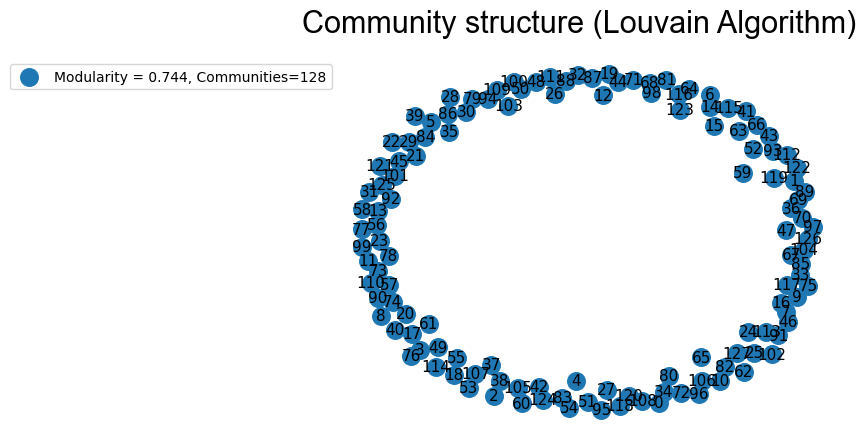

In [38]:
# Create a community table and merge it with the main table   
comm = pd.DataFrame({'Author': node_values, 'Community': values})
print(comm.head())
measure_df = measure_df.merge(comm, on='Author', how='left', suffixes=('', '_new')) # merge the dataframes with a suffix for the new column
measure_df.rename(columns={'Community_new': 'Community'}, inplace=True) # rename the new column to 'Community'
measure_df.to_csv('measure_df.csv')

# Create a dictionary with community number as key and a list of its participants as value
dict_nodes = {}
#print(partition.items())
for each_item in partition.items():
    community_num = each_item[1]
    community_node = each_item[0]
    if community_num in dict_nodes:
        #print(community_num)
        #print(community_node)

        value = dict_nodes.get(community_num) + ', ' + str(community_node)
        dict_nodes.update({community_num: value})
    else:
        dict_nodes.update({community_num: str(community_node)})

# Create a dataframe from the dictionary and save to a CSV file
community_df = pd.DataFrame.from_dict(dict_nodes, orient='index', columns=['Members'])
community_df.index.rename('Community_Num', inplace=True)
community_df.to_csv('Community_List_metions.csv')
print(community_df.shape)

# Create a new graph to represent the communities created by the Louvain algorithm
G_comm = nx.Graph()
G_comm.add_nodes_from(dict_nodes)

# Calculate modularity and the total number of communities
mod = community_louvain.modularity(partition, nw_G_nd)
print("Modularity for mention community: {}".format(mod))
print("Total number of Communities (mentions): {}".format(len(G_comm.nodes())))

# Create the graph and also calculate modularity
pos_louvain = nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True, node_size=160, font_size=11, label='Modularity = ' + str(round(mod,3)) + ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)', fontsize=22, fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
plt.savefig('louvain - mentions.png', dpi=400)


In [39]:
measure_df.head()

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community
0,usadapekora,30077,6544,0.035153,0.000011,2.508462e-06,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,1397443,0,14219,48806,0,0,1
1,youtubejapan,27958,22562,0.119870,0.001365,2.500629e-05,YouTubeJapan (YouTube Japan),individual,ja,520150,4082,34347,1033850,139,15370,2
2,niziu__official,23949,4346,0.023337,0.000016,1.501726e-05,NiziU__official (NiziU),organisational,ja,809129,462,13167,167395,22,726,16
3,haneru_inaba,16469,2278,0.012230,0.000011,2.769555e-11,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,203461,0,86212,22122,0,0,12
4,karekoreya,15925,1484,0.007963,0.000011,1.546821e-08,karekoreya (ヒサメ@混血のカレコレ),individual,ja,59485,37,2459,24136,4,267,14


In [ ]:
# Fine-tune the Louvain algorithm parameters. We can experiment with different values for the resolution_range and n_iterations parameters, as well as the weight parameter if your network has weighted edges.
#resolution_range = [0.01, 0.1, 1.0, 5.0, 10.0]
resolution_range = [0.01, 0.1, 1.0, 5.0, 10.0]
n_iterations = 10
weight = 'weight'

# Create a dictionary of partitions for each resolution value
dict_part = {}
for i in resolution_range:
    part = community_louvain.best_partition(nw_G_nd, weight=weight, random_state=2022, resolution=i)
    dict_part[i] = part

# Create a dataframe from the dictionary and save to a CSV file
part_df = pd.DataFrame.from_dict(dict_part, orient='index')
part_df.index.rename('Resolution', inplace=True)
part_df.to_csv('Resolution_Partitions_mentions.csv')

# Run the Louvain algorithm for each resolution value and calculate modularity
for i in resolution_range:
    partition = dict_part.get(i)
    mod = community_louvain.modularity(partition, nw_G_nd)
    print("Modularity for mention community (resolution = {}): {}".format(i, mod))
    print("Total number of Communities (mentions): {}".format(len(set(partition.values()))))
    print("")

Modularity for mention community (dense network): 0.744072249835347
Total number of Communities (mentions): 128
Modularity for mention community (dense network): 0.744072249835347
Total number of Communities (mentions): 128



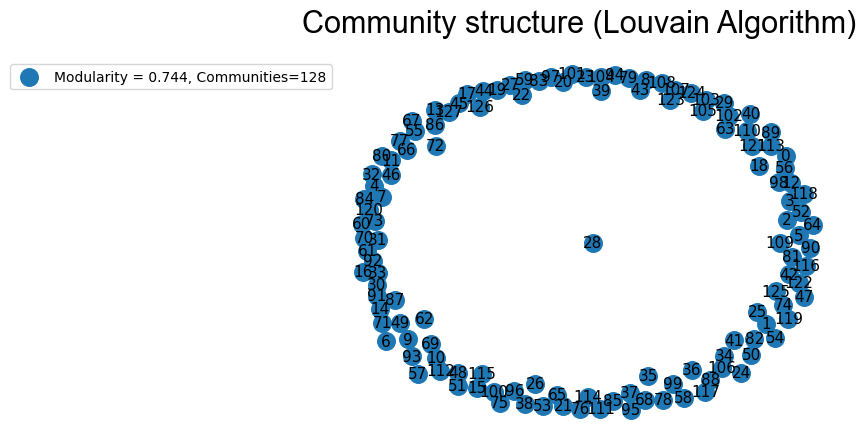

In [40]:
# Make the network edges more dense to increase the modularity
nw_G_nd_dense = nx.from_pandas_edgelist(network_data, 'Author', 'Mentioned Authors', edge_attr='weight', create_using=nx.Graph())
for edge in nw_G_nd_dense.edges():
    nw_G_nd_dense[edge[0]][edge[1]]['weight'] *= 1


# Calculate the modularity using the new network
partition = community_louvain.best_partition(nw_G_nd_dense, weight='weight', random_state=2022)
mod = community_louvain.modularity(partition, nw_G_nd_dense)
print("Modularity for mention community (dense network): {}".format(mod))
print("Total number of Communities (mentions): {}".format(len(set(partition.values()))))

# Create a list of node values and their corresponding partition values
node_values = []
values = []
for node in nw_G_nd_dense.nodes():
    node_values.append(node)
    values.append(partition.get(node))

# Create a community table and merge it with the main table
comm = pd.DataFrame({'Author': node_values, 'Community': values})

#measure_df = measure_df.merge(comm, on='Author', how='left', suffixes=('', '_new')) # merge the dataframes with a suffix for the new column
#measure_df.rename(columns={'Community_new': 'Community'}, inplace=True) # rename the new column to 'Community'
measure_df.to_csv('measure_df.csv')


# Create a dictionary with community number as key and a list of its participants as value
dict_nodes = {}
for each_item in partition.items():
    community_num = each_item[1]
    community_node = each_item[0]
    if community_num in dict_nodes:
        value = dict_nodes.get(community_num) + ', ' + str(community_node)
        dict_nodes.update({community_num: value})
    else:
        dict_nodes.update({community_num: str(community_node)})


# Create a dataframe from the dictionary and save to a CSV file
community_df = pd.DataFrame.from_dict(dict_nodes, orient='index', columns=['Members'])
community_df.index.rename('Community_Num', inplace=True)

# Create a new graph to represent the communities created by the Louvain algorithm
G_comm = nx.Graph()
G_comm.add_nodes_from(dict_nodes)

# Calculate modularity and the total number of communities
mod = community_louvain.modularity(partition, nw_G_nd_dense)
print("Modularity for mention community (dense network): {}".format(mod))
print("Total number of Communities (mentions): {}".format(len(G_comm.nodes())))
print("")

# Create the graph and also calculate modularity
pos_louvain = nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True, node_size=160, font_size=11, label='Modularity = ' + str(round(mod,3)) + ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)', fontsize=22, fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
plt.savefig('louvain - mentions - dense.png', dpi=400)



In [41]:
measure_df.head()

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community
0,usadapekora,30077,6544,0.035153,0.000011,2.508462e-06,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,1397443,0,14219,48806,0,0,1
1,youtubejapan,27958,22562,0.119870,0.001365,2.500629e-05,YouTubeJapan (YouTube Japan),individual,ja,520150,4082,34347,1033850,139,15370,2
2,niziu__official,23949,4346,0.023337,0.000016,1.501726e-05,NiziU__official (NiziU),organisational,ja,809129,462,13167,167395,22,726,16
3,haneru_inaba,16469,2278,0.012230,0.000011,2.769555e-11,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,203461,0,86212,22122,0,0,12
4,karekoreya,15925,1484,0.007963,0.000011,1.546821e-08,karekoreya (ヒサメ@混血のカレコレ),individual,ja,59485,37,2459,24136,4,267,14


In [42]:
# normalize the metric with logit transformation, turn the value into a range of [0,1] 
def hill_transform(x, ec, slope): # used to transport an infinite range to 0 to 1
   if x==0:
      return 0
   else:
      return 1 / (1 + (x / ec)**(-slope))

In [43]:
# Choosing metrics for scoring
metrics = ['in_degree_Centrality', 'out_degree_Centrality', 'eigenvector_centrality_in', 'Twitter_Followers', 'Reach']
avg_inflection = measure_df[metrics].mean()

# Normalize these 6 variables and store them in a new dataframe with only [0.1] range allowed; use logit transformation
measure_df_norm = measure_df.copy()
for metric in metrics:
    measure_df_norm[metric] = measure_df_norm[metric].apply(lambda x: hill_transform(x, avg_inflection[metric], 1))

# Show the normalized dataframe
measure_df_norm.head()

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community
0,usadapekora,30077,6544,0.999923,0.516048,0.287209,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,0.999337,0,14219,0.995652,0,0,1
1,youtubejapan,27958,22562,0.999978,0.992670,0.800669,YouTubeJapan (YouTube Japan),individual,ja,0.998219,4082,34347,0.999794,139,15370,2
2,niziu__official,23949,4346,0.999885,0.615308,0.706937,NiziU__official (NiziU),organisational,ja,0.998855,462,13167,0.998728,22,726,16
3,haneru_inaba,16469,2278,0.999780,0.516048,0.000004,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,0.995461,0,86212,0.990457,0,0,12
4,karekoreya,15925,1484,0.999662,0.516048,0.002479,karekoreya (ヒサメ@混血のカレコレ),individual,ja,0.984642,37,2459,0.991246,4,267,14


In [44]:
# Using in-degree centrality, out-degree centrality, Twitter followers, and reach to calculate the overall score
weights = [0.5, 0.3, 0.2]
overall_score_metrics = ['in_degree_Centrality', 'out_degree_Centrality', 'Reach']
measure_df_norm['Overall_Score'] = measure_df_norm[overall_score_metrics].dot(weights)
measure_df_norm.head()


,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community,Overall_Score
0,usadapekora,30077,6544,0.999923,0.516048,0.287209,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,0.999337,0,14219,0.995652,0,0,1,0.854275
1,youtubejapan,27958,22562,0.999978,0.992670,0.800669,YouTubeJapan (YouTube Japan),individual,ja,0.998219,4082,34347,0.999794,139,15370,2,0.997591
2,niziu__official,23949,4346,0.999885,0.615308,0.706937,NiziU__official (NiziU),organisational,ja,0.998855,462,13167,0.998728,22,726,16,0.884293
3,haneru_inaba,16469,2278,0.999780,0.516048,0.000004,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,0.995461,0,86212,0.990457,0,0,12,0.853296
4,karekoreya,15925,1484,0.999662,0.516048,0.002479,karekoreya (ヒサメ@混血のカレコレ),individual,ja,0.984642,37,2459,0.991246,4,267,14,0.852234


In [45]:
# Using eigenvector centrality instead of in-degree and out-degree to calculate the overall score
weights = [0.5, 0.3, 0.2]
overall_score_eigen_metrics = ['eigenvector_centrality_in', 'out_degree_Centrality', 'Reach']
measure_df_norm['Overall_Score_Eigenvector'] = measure_df_norm[overall_score_eigen_metrics].dot(weights)
measure_df_norm.head()

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community,Overall_Score,Overall_Score_Eigenvector
0,usadapekora,30077,6544,0.999923,0.516048,0.287209,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,0.999337,0,14219,0.995652,0,0,1,0.854275,0.497918
1,youtubejapan,27958,22562,0.999978,0.992670,0.800669,YouTubeJapan (YouTube Japan),individual,ja,0.998219,4082,34347,0.999794,139,15370,2,0.997591,0.897937
2,niziu__official,23949,4346,0.999885,0.615308,0.706937,NiziU__official (NiziU),organisational,ja,0.998855,462,13167,0.998728,22,726,16,0.884293,0.737819
3,haneru_inaba,16469,2278,0.999780,0.516048,0.000004,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,0.995461,0,86212,0.990457,0,0,12,0.853296,0.353408
4,karekoreya,15925,1484,0.999662,0.516048,0.002479,karekoreya (ヒサメ@混血のカレコレ),individual,ja,0.984642,37,2459,0.991246,4,267,14,0.852234,0.353643


In [46]:
# Add the column of overall_score and overall_score_eigenvector to the original measure_df for the corresponding author
measure_df['Overall_Score'] = measure_df_norm['Overall_Score']
measure_df['Overall_Score_Eigenvector'] = measure_df_norm['Overall_Score_Eigenvector']

# Save the measure_df to a CSV file
measure_df.to_csv('measure_df_vF.csv')



In [47]:
measure_df.head(10)

,Author,Weighted Degree,Degree,in_degree_Centrality,out_degree_Centrality,eigenvector_centrality_in,Full_Name,Account_Type,Language,Twitter_Followers,Twitter_Retweets,Twitter_Tweets_max,Reach,Twitter_Reply_Count,Twitter_Tweets_within,Community,Overall_Score,Overall_Score_Eigenvector
0,usadapekora,30077,6544,0.035153,0.000011,2.508462e-06,usadapekora (兎田ぺこら👯‍♀️ホロライブ3期生),individual,ja,1397443,0,14219,48806,0,0,1,0.854275,0.497918
1,youtubejapan,27958,22562,0.119870,0.001365,2.500629e-05,YouTubeJapan (YouTube Japan),individual,ja,520150,4082,34347,1033850,139,15370,2,0.997591,0.897937
2,niziu__official,23949,4346,0.023337,0.000016,1.501726e-05,NiziU__official (NiziU),organisational,ja,809129,462,13167,167395,22,726,16,0.884293,0.737819
3,haneru_inaba,16469,2278,0.012230,0.000011,2.769555e-11,Haneru_Inaba (因幡はねる💛🐰有閑喫茶あにまーれ💛),individual,ja,203461,0,86212,22122,0,0,12,0.853296,0.353408
4,karekoreya,15925,1484,0.007963,0.000011,1.546821e-08,karekoreya (ヒサメ@混血のカレコレ),individual,ja,59485,37,2459,24136,4,267,14,0.852234,0.353643
5,laplusdarknesss,13905,7401,0.039747,0.000021,7.463208e-06,LaplusDarknesss (ラプラス・ダークネス🛸💜21日23時からAPEX配信！),individual,ja,946498,0,8489,41773,0,0,1,0.903595,0.676234
6,amon_yuuku,11933,1509,0.008098,0.000011,2.180798e-09,Amon_Yuuku (鴉紋ゆうく),individual,ja,34227,18,5116,14758,0,1088,37,0.850585,0.350927
7,shirakamifubuki,11545,5516,0.029629,0.000011,2.150659e-14,shirakamifubuki (白上フブキ@KONKONBeats🌽),individual,ja,1445766,0,105321,49470,0,0,1,0.854276,0.354321
8,chigusa_24zono,9854,2653,0.014250,0.000005,1.889374e-12,Chigusa_24zono (西園チグサ🐬🌱),individual,ja,336505,50,14803,41065,1,0,8,0.803440,0.303535
9,rene_ryugasaki,8980,1791,0.009618,0.000005,1.672946e-14,Rene_Ryugasaki (龍ヶ崎リン🦒@シュガリリ),individual,ja,51142,0,11927,11882,0,0,12,0.800642,0.300782
